## General

In [299]:
# Import libraries
import string
import random
import numpy as np
import networkx as nx
from numpy import linalg as LA
import matplotlib.pyplot as plt

## Load Map

In [300]:
# Load map
map_ = np.loadtxt("simple-map-dungeon.txt").astype(int)

## Graph Creation (NetworkX)

In [301]:
# Create graph instance
G = nx.Graph()

# Populate graph by creating
# edges between neighbours
for y in range(map_.shape[0]):
    for x in range(map_.shape[1]):
        # Skip iteration if obstacle
        if map_[y,x]:
            continue
        
        # Add edge to non-obstacle element to the right
        if y+1 < map_.shape[0] and map_[y+1,x] == 0:
            G.add_edge((x,y),(x,y+1))
        
        # Add edge to non-obstacle element to the left
        if y-1 >= 0 and  map_[y-1,x] == 0:
            G.add_edge((x,y),(x,y-1))
        
        # Add edge to non-obstacle element to the bottom
        if x+1 < map_.shape[1] and  map_[y,x+1] == 0:
            G.add_edge((x,y),(x+1,y))
        
        # Add edge to non-obstacle element to the top
        if x-1 >= 0 and  map_[y,x-1] == 0:
            G.add_edge((x,y),(x-1,y))

## Source-Target Distances

In [302]:
# Compute dictionary of distances
# between any node and any other one
D = nx.shortest_path(G)

## K-medoids clustering

In [307]:
# Global variables
K = 4
TMAX = 100

# Medoids list
medoids = []

# Pick randomly medoids
# among the nodes of the
# graph
for i in range(K):
    medoids.append(random.choice(list(G.nodes())))

# Iterate over tmax
for epoch in range(TMAX):
    # Medoids clusters
    k_med_clusters = [set() for _ in range(K)]
    
    # Populate clusters for
    # each medoid set
    for node in G.nodes():
        # Temp variables to
        # keep track of closest
        # medoids
        best_idx = None
        best_medoid = None
        min_distance = np.inf
        
        # Iterate over medoids
        for idx, medoid in enumerate(medoids):
            # Fetch shortest path distance
            distance = len(D[node][medoid])
            
            # Update min distance
            # and respective closest
            # medoid
            if distance < min_distance:
                best_idx = idx
                best_medoid = medoid
                min_distance = distance
        
        # Add vertex to closest cluster
        k_med_clusters[best_idx].add(node)

    # Update medoid based on updated clusters
    for idx, k_med_cluster in enumerate(k_med_clusters):
        # Temp variables
        best_medoid = None
        min_distance = np.inf
        
        # Iterate over ith cluster
        for node_j in k_med_cluster:
            # Compute sum distance for each
            # cluster points with respect to
            # all other points in the cluster
            sum_distance = sum(len(D[node_j][node_l]) for node_l in k_med_cluster)
            
            # Update min distance and
            # respective best medoid
            if sum_distance < min_distance:
                best_medoid = node_j
                min_dist = sum_distance
        
        # Update medoid
        medoids[idx] = best_medoid  

## K-Medoids Clustering

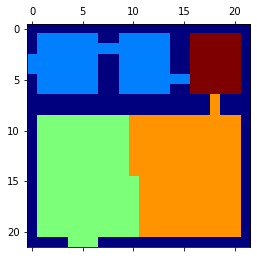

In [308]:
# Medoids cluster map
medoids_cluster = map_.copy()

# Loop over map and set cluster k
for y in range(map_.shape[0]):
    for x in range(map_.shape[1]):
        # Check if entry is free
        if map_[y,x] == 0:
            # Check which cluster it belongs to
            for idx, k_med_cluster in enumerate(k_med_clusters):
                if (x,y) in k_med_cluster:
                    medoids_cluster[y, x] = idx + 1
        else:
            medoids_cluster[y, x] = 0

plt.matshow(medoids_cluster, cmap='jet', interpolation='nearest')
plt.show()

## Spectral Clustering

In [221]:
# Compute adjacency matrix
A = nx.adjacency_matrix(G).todense()

# Create degree matrix
D = np.zeros((A.shape[0], A.shape[1]))

# Populate degree matrix
for y in range(A.shape[0]):
    degree = 0
    for x in range(A.shape[1]):
        degree += A[y,x]
    
    # Update degree for node y
    D[y, y] = degree

# Compute the laplacian graph
L = D - A

# Perform EigenValue Decomposition
w, v = LA.eigh(L)

# Sort eigenvalues and eigenvectors
sort_idx = w.argsort() 
w = w[sort_idx]
v = v[sort_idx]

# Fetch the first K eigenvectors
v_k = v[:, 1:K+1]

# Select randomly k clusters
centroids = []
for _ in range(K):
    # Get random choice input
    choice = random.choice(v_k)
    
    # Populate clusters
    centroids.append(np.array(choice)[0].tolist())

print("Initial centroids: ", centroids)
    
# # Populate clusters
# centroids.append(np.array(v_k[4])[0].tolist())
# centroids.append(np.array(v_k[50])[0].tolist())
# centroids.append(np.array(v_k[100])[0].tolist())
# centroids.append(np.array(v_k[250])[0].tolist())

# Perform k-means on data points
for _ in range(10):
    # Clusters as a list of lists
    k_mean_clusters = [[] for _ in range(K)]
    
    # Iterate over datapoints
    for x in range(v_k.shape[0]):
        # Temp variables
        best_idx = None
        min_distance = np.inf
        best_centroid = None
        
        # Iterate over clusters
        for idx, centroid in enumerate(centroids):
            # Compute euclidean distance
            # between node and centroid
            distance = np.linalg.norm(np.array(v_k[x])[0].tolist() - np.array(centroid))
            
            # Get best centroid for
            # datapoint in the spectrals
            if  distance < min_distance:
                best_idx = idx
                min_distance = distance
                best_centroid = centroid
            
        # Add node to respective cluster
        k_mean_clusters[best_idx].append(np.array(v_k[x]))
        
    # Update centroids
    for i, cluster in enumerate(k_mean_clusters):
        # Temp variable
        sum_ = np.asarray([0.0,0.0,0.0,0.0])
        
        # Loop over points in ith cluster
        for point in cluster:
            sum_ += point[0].tolist()
        
        # Update centroid as mean
        centroids[i] = sum_ / len(cluster)

print("\n")
# print("Final centroids: ", centroids)

Initial centroids:  [[0.03143861514397576, 0.007269924439474234, -0.011032734097554717, -0.021854151843952806], [-0.03162762794120606, -0.13120856885983886, -0.0714181036413649, 0.07685627116046613], [0.032801808753442574, 0.010234975645740732, -0.016001834484639894, -0.041069938636627855], [-0.07556976577777921, -0.07143281721006801, 0.11622814972251438, -0.05499482384707441]]




## Spectral Clustering

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 0 0 4 4 4 4 4 0 0 2 2 2 2 2 0]
 [0 1 1 1 1 1 1 1 4 4 4 4 4 4 0 0 2 2 2 2 2 0]
 [1 1 1 1 1 1 1 0 0 4 4 4 4 4 0 0 2 2 2 2 2 0]
 [1 1 1 1 1 1 1 0 0 4 4 4 4 4 0 0 2 2 2 2 2 0]
 [0 1 1 1 1 1 1 0 0 4 4 4 4 4 4 2 2 2 2 2 2 0]
 [0 1 1 1 1 1 1 0 0 4 4 4 4 4 0 0 2 2 2 2 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 0]
 [0 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 0]
 [0 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 0]
 [0 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 0]
 [0 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 0]
 [0 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 0]
 [0 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 0]
 [0 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 0]
 [0 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 0]
 [0 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 0]
 [0 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 0]
 [0 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 0]
 [0 0 0 0 1 1

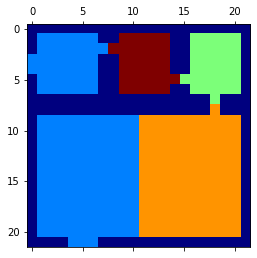

In [222]:
# List of nodes
nodes = list(G.nodes())

# Copy of original map
map_clustered = np.zeros_like(map_)

# Iterate over all clusters
for idx, k_mean_cluster in enumerate(k_mean_clusters):
    # Iterate over all points in the cluster
    for point in k_mean_cluster:
        # Find where point matches
        i, _ = np.where(np.isclose(v_k, point).all(axis=1))
#         print(i)
                
        # Get corresponding i,j in map for match
        x,y = nodes[i[0]]
        
#         print(y,x)
        
        # Update map
        map_clustered[y,x] = idx + 1

print(map_clustered)
# print(k_mean_clusters)

plt.matshow(map_clustered, cmap='jet', interpolation='nearest')
plt.show()

In [124]:
centroids

[array([-0.02962233, -0.12702364, -0.0708686 ,  0.07187703]),
 array([-0.09837767,  0.01874823,  0.02873321, -0.01622339]),
 array([0.03541653, 0.02103087, 0.03139886, 0.0427249 ]),
 array([ 0.02955782,  0.00121351, -0.03003573, -0.05292039])]